In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-clothing-store/products_skus.csv
/kaggle/input/ecommerce-clothing-store/products.csv
/kaggle/input/ecommerce-clothing-store/traffic.csv
/kaggle/input/ecommerce-clothing-store/orders_items.csv
/kaggle/input/ecommerce-clothing-store/orders.csv
/kaggle/input/ecommerce-clothing-store/customers.csv
/kaggle/input/ecommerce-clothing-store/transactions.csv


### 1. Business Understanding

#### This project is based on a e-commerce clothing startup 👚👗👠👢. 
#### The goal is to explore customers and sales trends and behaviors to give the business some insights and strategies to boost sales 📦📦📦📦. 
#### Major analyses are as follows:
* traffic & sales trend analysis

### 2. Data Understanding

In [2]:
# load data
# customer => website (traffic) => product/product sku => order/order items => transaction
customers = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/customers.csv').rename(columns={'id':'customer_id', 'created_at':'customer_created_at'})
traffic = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/traffic.csv').drop(columns=['index'])
products = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products.csv').rename(columns={'id':'product_id', 'title':'product_title', 'created_at':'product_created_at', 'published_at':'product_published_at'})
prod_sku = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/products_skus.csv').rename(columns={'id':'product_sku_id', 'created_at':'sku_created_at'})
orders = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders.csv').rename(columns={'id':'order_id', 'created_at':'order_created_at', 'closed_at':'order_closed_at', 'cancelled_at':'order_cancelled_at', 'processed_at': 'order_processed_at'})
ord_item = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/orders_items.csv').rename(columns={'id':'order_product_id'})
transactions = pd.read_csv(r'/kaggle/input/ecommerce-clothing-store/transactions.csv').rename(columns={'id':'transaction_id', 'created_at':'transaction_created_at', 'status':'transaction_status', 'kind':'transaction_kind', 'amount':'transaction_amount'})

col_dict = {}
col_dict['customers'] = customers.columns.tolist()
col_dict['traffic'] = traffic.columns.tolist()
col_dict['products'] = products.columns.tolist()
col_dict['prod_sku'] = prod_sku.columns.tolist()
col_dict['orders'] = orders.columns.tolist()
col_dict['ord_item'] = ord_item.columns.tolist()
col_dict['transactions'] = transactions.columns.tolist()

print('customers:', col_dict['customers'])
print('traffic:', col_dict['traffic'])
print('products:', col_dict['products'])
print('prod_sku:', col_dict['prod_sku'])
print('orders:', col_dict['orders'])
print('ord_item:', col_dict['ord_item'])
print('transactions:', col_dict['transactions'])

customers: ['customer_id', 'full_name', 'customer_created_at']
traffic: ['date_day', 'page_views', 'sessions', 'product_detail_views', 'product_checkouts', 'product_adds_to_carts', 'avg_session_in_s']
products: ['product_id', 'product_title', 'product_type', 'product_created_at', 'product_published_at']
prod_sku: ['product_sku_id', 'product_id', 'product_style', 'sku', 'sku_created_at', 'price']
orders: ['order_id', 'order_created_at', 'order_closed_at', 'order_cancelled_at', 'customer_id', 'financial_status', 'fulfillment_status', 'order_processed_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']
ord_item: ['order_product_id', 'order_id', 'product_id', 'product_style', 'variant_id', 'sku', 'product_title', 'fulfillment_status', 'price', 'quantity']
transactions: ['order_id', 'transaction_id', 'parent_id', 'transaction_amount', 'error_code', 'transaction_kind', 'transaction_status', 'transaction_created_at']


#### No. Customers:

In [3]:
print("There are {} customers, {} don't have full names.".format(customers['customer_id'].nunique(), customers['full_name'].isnull().sum()))
print("{} are unique full names and {} are duplicates.".format(customers['full_name'].nunique(), customers['customer_id'].nunique() - customers['full_name'].nunique()))

There are 44661 customers, 10962 don't have full names.
28638 are unique full names and 16023 are duplicates.


#### Traffic (Pageviews):

Avg. daily # pageviews = 18542
Medium. daily # pageviews = 10417
# outliers = 9 [625003, 220707, 226285, 137956, 169100, 187239, 192006, 136682, 160544]


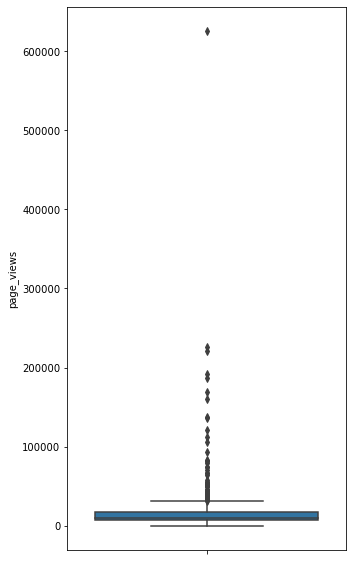

In [4]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='page_views')
print('Avg. daily # pageviews = {:.0f}'.format(traffic['page_views'].mean()))
print('Medium. daily # pageviews = {:.0f}'.format(traffic['page_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['page_views'])) > 3, 'page_views'].tolist()))

* #### No. Product Detail Pageviews:

Avg. daily # product detail pageviews = 4957
Median daily # product detail pageviews = 2670
# outliers = 8 [175257, 58940, 65644, 34996, 60816, 60005, 57313, 40927]


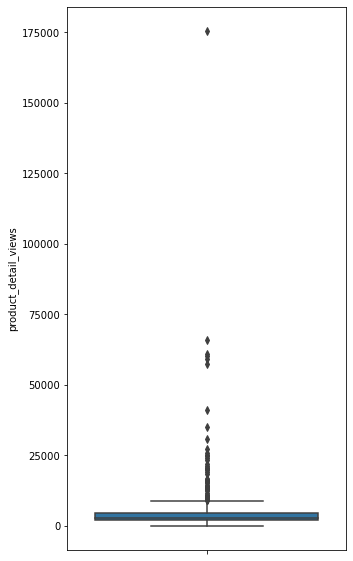

In [6]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_detail_views')
print('Avg. daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].mean()))
print('Median daily # product detail pageviews = {:.0f}'.format(traffic['product_detail_views'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_detail_views'])) > 3, 'product_detail_views'].tolist()))

#### No. Add2Carts:

Avg. daily # add-to-carts = 499
Median daily # add-to-carts = 262
# outliers = 9 [10851, 4763, 4301, 5700, 9450, 3408, 8299, 3273, 4434]


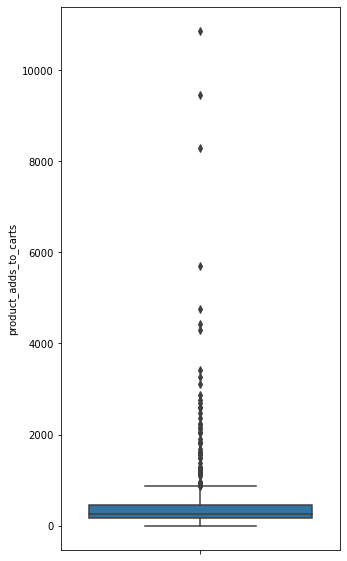

In [7]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_adds_to_carts')
print('Avg. daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].mean()))
print('Median daily # add-to-carts = {:.0f}'.format(traffic['product_adds_to_carts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_adds_to_carts'])) > 3, 'product_adds_to_carts'].tolist()))

#### No. Checkouts:

Avg. daily # checkouts = 146
Median daily # checkouts = 62
# outliers = 9 [5639, 2001, 1644, 1228, 1840, 1312, 1852, 1794, 1378]


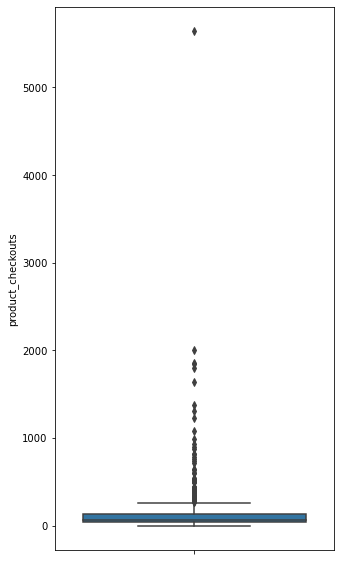

In [8]:
plt.figure(figsize=(5,10))
sns.boxplot(data=traffic, y='product_checkouts')
print('Avg. daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].mean()))
print('Median daily # checkouts = {:.0f}'.format(traffic['product_checkouts'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].count(), traffic.loc[np.abs(stats.zscore(traffic['product_checkouts'])) > 3, 'product_checkouts'].tolist()))

#### Sessions:

Avg. daily # sessions = 4461
Median daily # sessions = 2693
# outliers = 9 [146860, 61654, 46927, 31815, 31239, 32166, 36614, 45385, 35921]


Avg. of daily average session in seconds = 145.32655160450236
Median. of daily average session in seconds = 132.607292539816
# outliers = 4 [2374.16666666667, 1632.11111111111, 1891.25, 1557.95652173913]


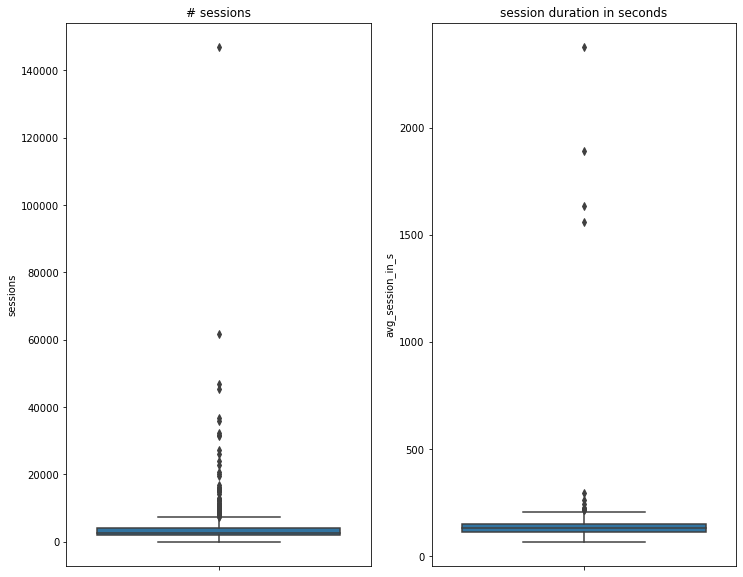

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
sns.boxplot(data=traffic, y='sessions', ax=ax1)
ax1.set_title('# sessions')
sns.boxplot(data=traffic, y='avg_session_in_s', ax=ax2)
ax2.set_title('session duration in seconds')
print('Avg. daily # sessions = {:.0f}'.format(traffic['sessions'].mean()))
print('Median daily # sessions = {:.0f}'.format(traffic['sessions'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].count(), traffic.loc[np.abs(stats.zscore(traffic['sessions'])) > 3, 'sessions'].tolist()))
print('\n')
print('Avg. of daily average session in seconds = {}'.format(traffic['avg_session_in_s'].mean()))
print('Median. of daily average session in seconds = {}'.format(traffic['avg_session_in_s'].median()))
print('# outliers = {} {}'.format(traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].count(), traffic.loc[np.abs(stats.zscore(traffic['avg_session_in_s'])) > 3, 'avg_session_in_s'].tolist()))

#### Products:

There are 247 products and 28 product types.
* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...


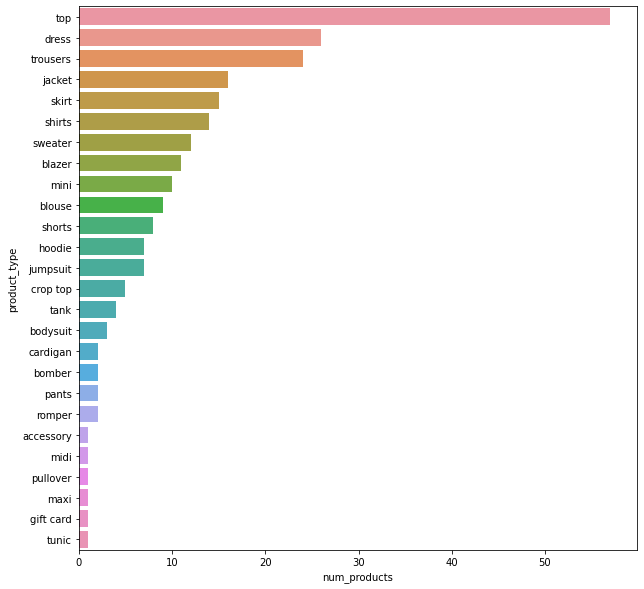

In [10]:
print('There are {} products and {} product types.'.format(products['product_id'].nunique(), products['product_type'].nunique()))
print('* Hooide==hoodie, Tousers==Trousers, and mixed-cases to be improved...')

products['product_type'] = products['product_type'].str.lower()
products.loc[lambda x: x['product_type'] == 'tousers', 'product_type'] = 'trousers'
products.loc[lambda x: x['product_type'] == 'hooide', 'product_type'] = 'hoodie'
plt.figure(figsize=(10, 10))
sns.barplot(data=products.groupby(['product_type'])['product_id'].count().reset_index().rename(columns={'product_id':'num_products'}).sort_values(by=['num_products'], ascending=False), 
            x='num_products',
            y='product_type');

#### Product SKU (Stock Keeping Unit):

In [12]:
print('There are {} SKUs, which means some products have multiple SKUs.'.format(prod_sku['sku'].nunique()))

There are 1353 SKUs, which means some products have multiple SKUs.


There are 5 outliers: [['gift card', 300.0], [nan, 150.0], [nan, 150.0], [nan, 150.0], [nan, 150.0]]


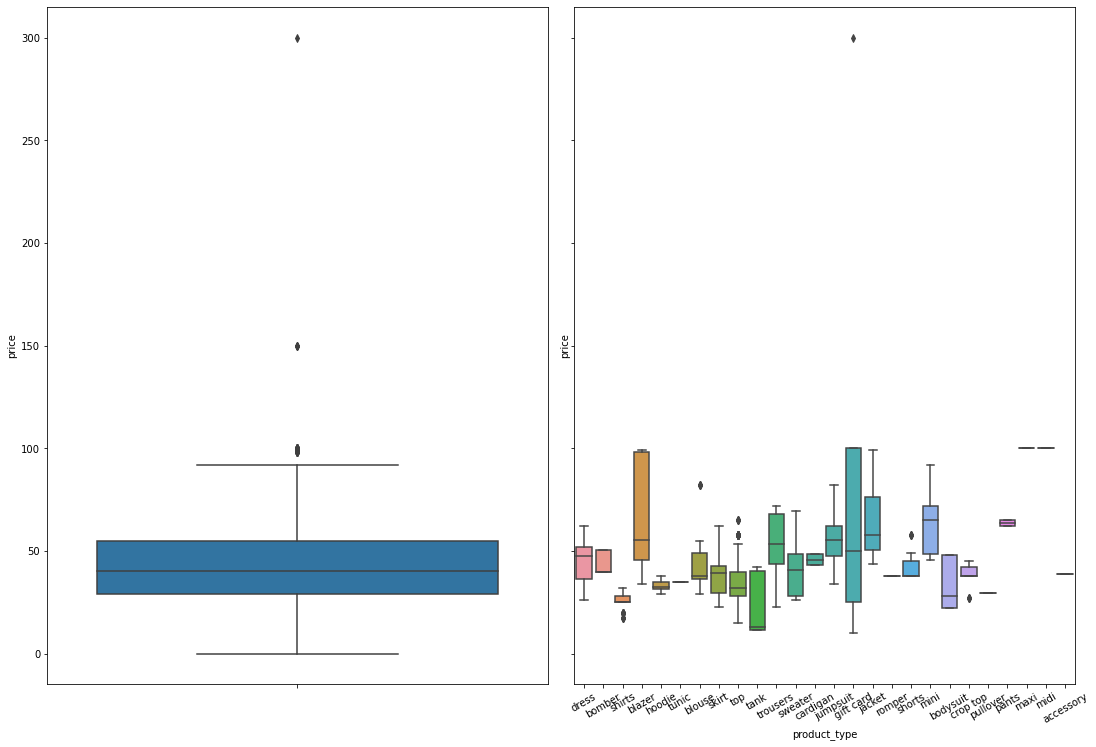

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)
fig.tight_layout()
sns.boxplot(data=prod_sku, y='price', ax=ax1)
sns.boxplot(data=pd.merge(products, prod_sku, on='product_id'), y='price', x='product_type', ax=ax2)
ax2.set_xticklabels(labels=ax2.get_xticklabels(), rotation=30);
print('There are {} outliers: {}'.format(prod_sku.loc[np.abs(stats.zscore(prod_sku['price'])) > 3].shape[0], pd.merge(products, prod_sku, on='product_id').loc[lambda x: np.abs(stats.zscore(x['price'])) > 3, ['product_type', 'price']].values.tolist()))

#### Orders:

In [14]:
print('There are {} orders.'.format(orders['order_id'].nunique()))

There are 21358 orders.


In [15]:
print(orders[['order_created_at', 'order_processed_at', 'order_closed_at', 'order_cancelled_at']].notnull().drop_duplicates().reset_index(drop=True), '\n')
print("Order creation & process date doesn't have NaNs, and theoretically order close date should be later than order cancel date.")
print('* There are {} record having close date before cancel date.'.format(orders.loc[lambda x: x['order_closed_at'] < x['order_cancelled_at']].shape[0]))

   order_created_at  order_processed_at  order_closed_at  order_cancelled_at
0              True                True             True                True
1              True                True             True               False
2              True                True            False                True
3              True                True            False               False 

Order creation & process date doesn't have NaNs, and theoretically order close date should be later than order cancel date.
* There are 1 record having close date before cancel date.


In [16]:
print("When orders haven't been closed yet, most of them are not fulfilled or only partially fulfilled: \n{}".format(orders.loc[lambda x: x['order_closed_at'].isnull()]['fulfillment_status'].value_counts(dropna=False).to_dict()))
print("Once they are fulfilled, the financial status are: \n{}".format(orders.loc[lambda x: x['order_closed_at'].isnull() & (x['fulfillment_status'] == 'fulfilled')]['financial_status'].value_counts(dropna=False).to_dict()))

When orders haven't been closed yet, most of them are not fulfilled or only partially fulfilled: 
{nan: 658, 'partial': 308, 'fulfilled': 195, 'restocked': 2}
Once they are fulfilled, the financial status are: 
{'partially_refunded': 180, 'refunded': 15}


#### Fulfillment Status:

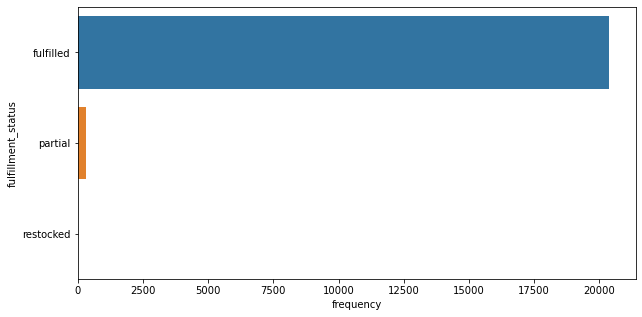

In [17]:
plt.figure(figsize=(10, 5))
sns.barplot(data=orders['fulfillment_status'].value_counts(dropna=True).reset_index().rename(columns={'index':'fulfillment_status', 'fulfillment_status':'frequency'}), x='frequency', y='fulfillment_status');

#### Financial Status:

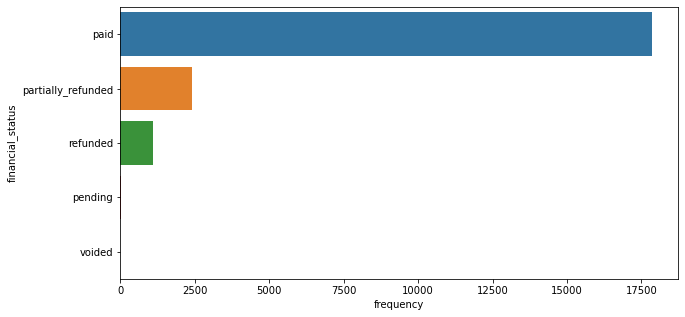

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(data=orders['financial_status'].value_counts(dropna=True).reset_index().rename(columns={'index':'financial_status', 'financial_status':'frequency'}), x='frequency', y='financial_status');

#### Order Size:

Some stats for # items/order: 
count    21355.000000
mean         1.735659
std          1.712648
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        127.000000
Name: quantity, dtype: float64


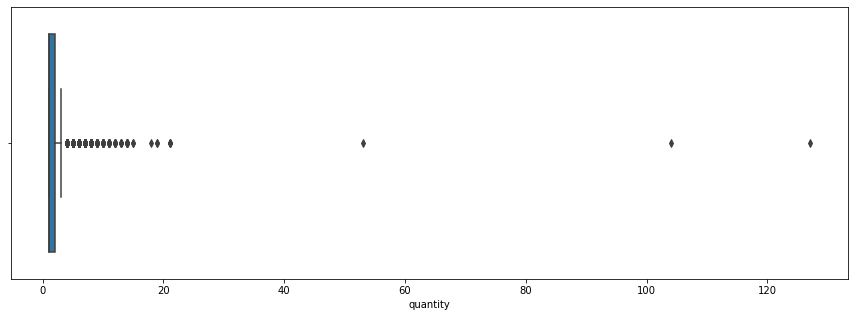

In [19]:
plt.figure(figsize=(15, 5))
print('Some stats for # items/order: \n{}'.format(pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index()['quantity'].describe()))
sns.boxplot(data=pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index(), x='quantity');

In [20]:
print('For those orders having greater than 6 items:')
order_over_6 = pd.merge(products, ord_item, on='product_id').groupby(['order_id'])['quantity'].sum().reset_index().loc[lambda x: x['quantity'] > 6]['order_id']
temp = pd.merge(products, ord_item, on='product_id')
temp1 = pd.pivot_table(temp.loc[lambda x: x['order_id'].isin(order_over_6)],
               index='order_id',
               columns=['product_type'],
               values=['quantity'],
               aggfunc='sum',
               fill_value=0).reset_index()
temp1.columns[1]
temp1.columns = [temp1.columns[0][0]] + [temp1.columns[i][1] for i in range(1, len(temp1.columns))]
temp1 = temp1.set_index('order_id')

temp1['item_freq'] = temp1.apply(lambda x: {col:x[col] for col in temp1.columns if x[col] > 0}, axis=1)
temp1.head(10)

For those orders having greater than 6 items:


,accessory,blazer,blouse,bodysuit,bomber,cardigan,crop top,dress,hoodie,jacket,...,romper,shirts,shorts,skirt,sweater,tank,top,trousers,tunic,item_freq
order_id,,,,,,,,,,,,,,,,,,,,,
7677426655,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,2,1,2,"{'blazer': 1, 'hoodie': 1, 'top': 2, 'trousers..."
7677510111,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,2,0,"{'blouse': 1, 'dress': 1, 'jumpsuit': 1, 'pull..."
7677553375,0,1,0,0,0,0,0,0,1,2,...,0,0,0,1,0,0,1,1,0,"{'blazer': 1, 'hoodie': 1, 'jacket': 2, 'jumps..."
7677789535,0,1,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,"{'blazer': 1, 'blouse': 2, 'bomber': 1, 'pullo..."
7679159967,0,1,2,1,0,0,0,2,0,0,...,0,0,0,1,0,0,1,4,1,"{'blazer': 1, 'blouse': 2, 'bodysuit': 1, 'dre..."
7679313183,0,1,2,1,0,0,0,2,0,0,...,0,0,0,1,0,0,1,4,1,"{'blazer': 1, 'blouse': 2, 'bodysuit': 1, 'dre..."
7695684319,0,0,0,1,0,0,0,1,0,1,...,0,3,0,0,0,0,0,1,0,"{'bodysuit': 1, 'dress': 1, 'jacket': 1, 'jump..."
7763091807,0,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,2,1,"{'bomber': 1, 'hoodie': 1, 'jacket': 1, 'shirt..."
7769898527,0,2,0,0,1,0,0,0,0,0,...,0,2,0,1,0,0,3,3,0,"{'blazer': 2, 'bomber': 1, 'shirts': 2, 'skirt..."


#### Order Price:

The order price follows this order: total_line_items_price ==> total_discounts ==> subtotal_price ==> shipping_rate ==> total_price
* (+) means add-on price, (-) means deduct price.


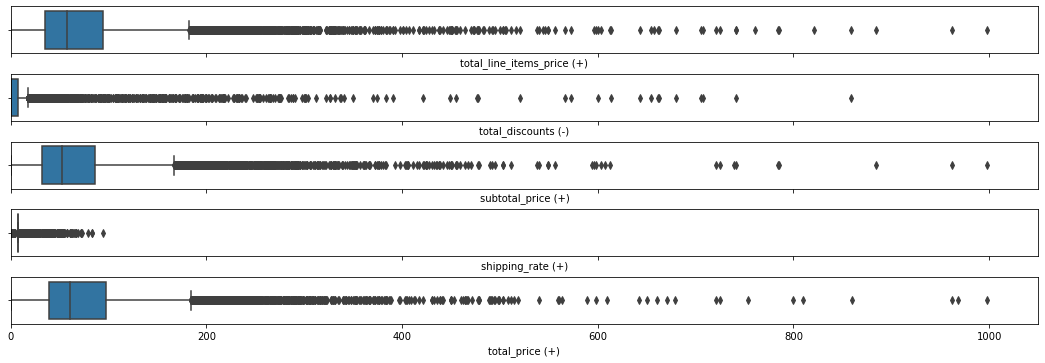

In [21]:
temp = orders[['total_line_items_price', 'total_discounts', 'subtotal_price', 'shipping_rate', 'total_price']]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(15, 5))
fig.tight_layout()
sns.boxplot(data=temp, x='total_line_items_price', ax=ax1)
sns.boxplot(data=temp, x='total_discounts', ax=ax2)
sns.boxplot(data=temp, x='subtotal_price', ax=ax3)
sns.boxplot(data=temp, x='shipping_rate', ax=ax4)
sns.boxplot(data=temp, x='total_price', ax=ax5);

ax1.set_xlabel('total_line_items_price (+)')
ax2.set_xlabel('total_discounts (-)')
ax3.set_xlabel('subtotal_price (+)')
ax4.set_xlabel('shipping_rate (+)')
ax5.set_xlabel('total_price (+)')

plt.xlim((0, 1050));
print('The order price follows this order: {}'.format(' ==> '.join(temp.columns.tolist())))
print('* (+) means add-on price, (-) means deduct price.')

#### Item Price:

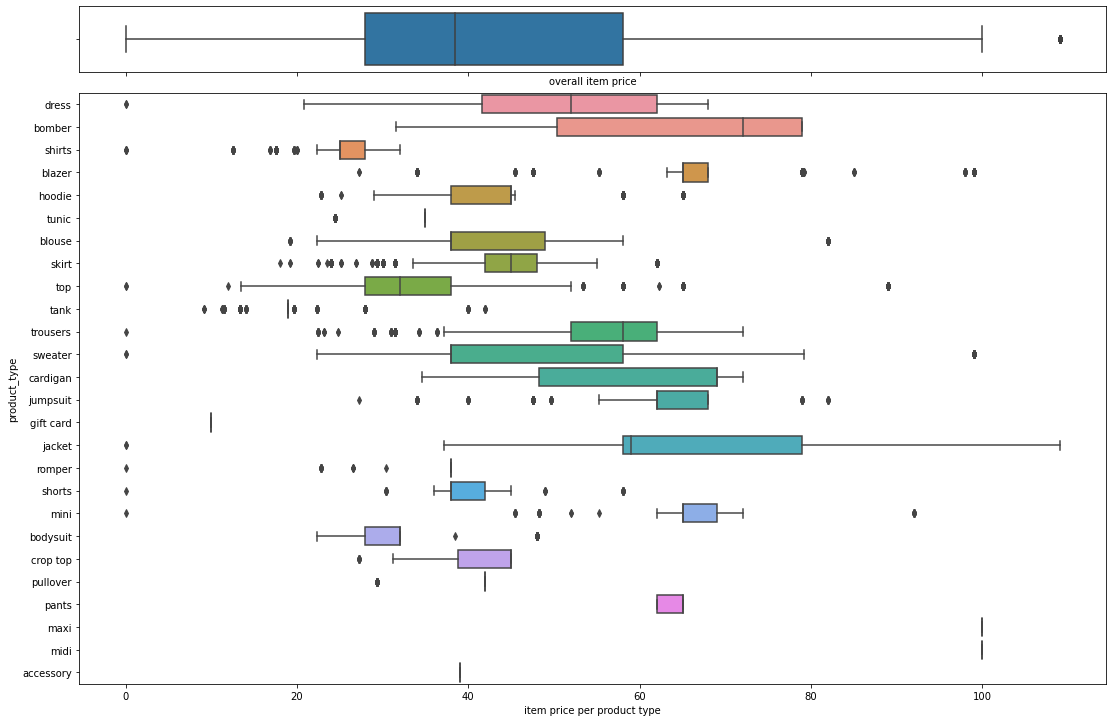

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 9]})
fig.tight_layout()
sns.boxplot(data=ord_item, x='price', ax=ax1)
ax1.set_xlabel('overall item price')
sns.boxplot(data=pd.merge(products, ord_item, on='product_id'), x='price', y='product_type', ax=ax2)
ax2.set_xlabel('item price per product type');

#### Transactions:

In [23]:
temp = pd.merge(orders, transactions, on='order_id')[['total_price', 'transaction_amount', 'transaction_kind', 'transaction_status']]
print('Order total price == transaction price? There are {} not equal.'.format(temp.loc[lambda x: x['total_price'] != x['transaction_amount']].shape[0]))
temp.loc[lambda x: x['total_price'] != x['transaction_amount']]['transaction_kind'].value_counts()

Order total price == transaction price? There are 3306 not equal.


refund           2831
sale              452
authorization      12
capture             7
void                4
Name: transaction_kind, dtype: int64

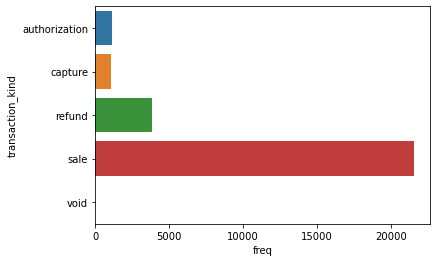

In [24]:
sns.barplot(data=temp.groupby(['transaction_kind'])['transaction_amount'].count().reset_index().rename(columns={'transaction_amount':'freq'}), y='transaction_kind', x='freq');

### Sales Trend & Seasonality

* Sales trend by daily traffic

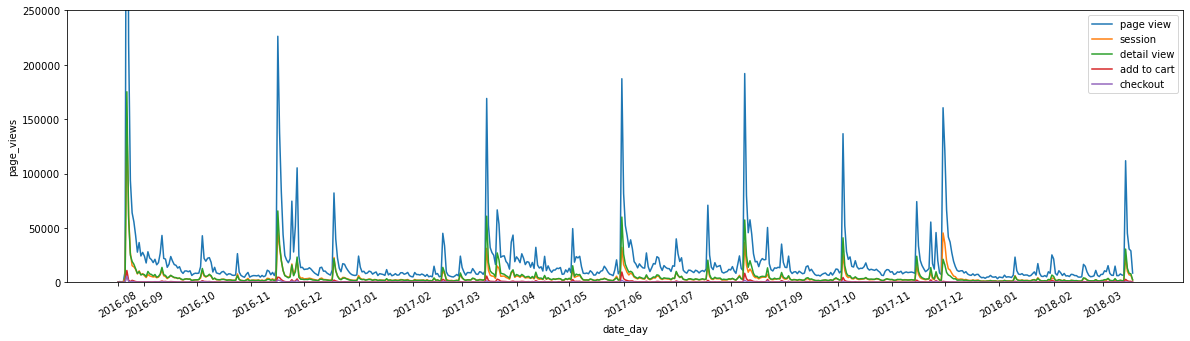

In [25]:
sales_trend_by_traffic = traffic.copy()
sales_trend_by_traffic['y_m'] = sales_trend_by_traffic['date_day'].apply(lambda x: x[:7])
fig, ax = plt.subplots(figsize=(20, 5))
plt.ylim((0, 250000))
# pageview - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='page_views', ax=ax, label='page view')
# sessions - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='sessions', ax=ax, label='session')
# prduct detail view - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_detail_views', ax=ax, label='detail view')
# product add to cart - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_adds_to_carts', ax=ax, label='add to cart')
# product checkouts - time
sns.lineplot(data=sales_trend_by_traffic.sort_values(by=['date_day']), x='date_day', y='product_checkouts', ax=ax, label='checkout')

plt.xticks(ticks=sales_trend_by_traffic.reset_index().groupby(['y_m'])['index'].first().tolist(), labels=sales_trend_by_traffic.reset_index().groupby(['y_m'])['index'].first().index.tolist(), rotation=30);

* Sales trend by daily sold items

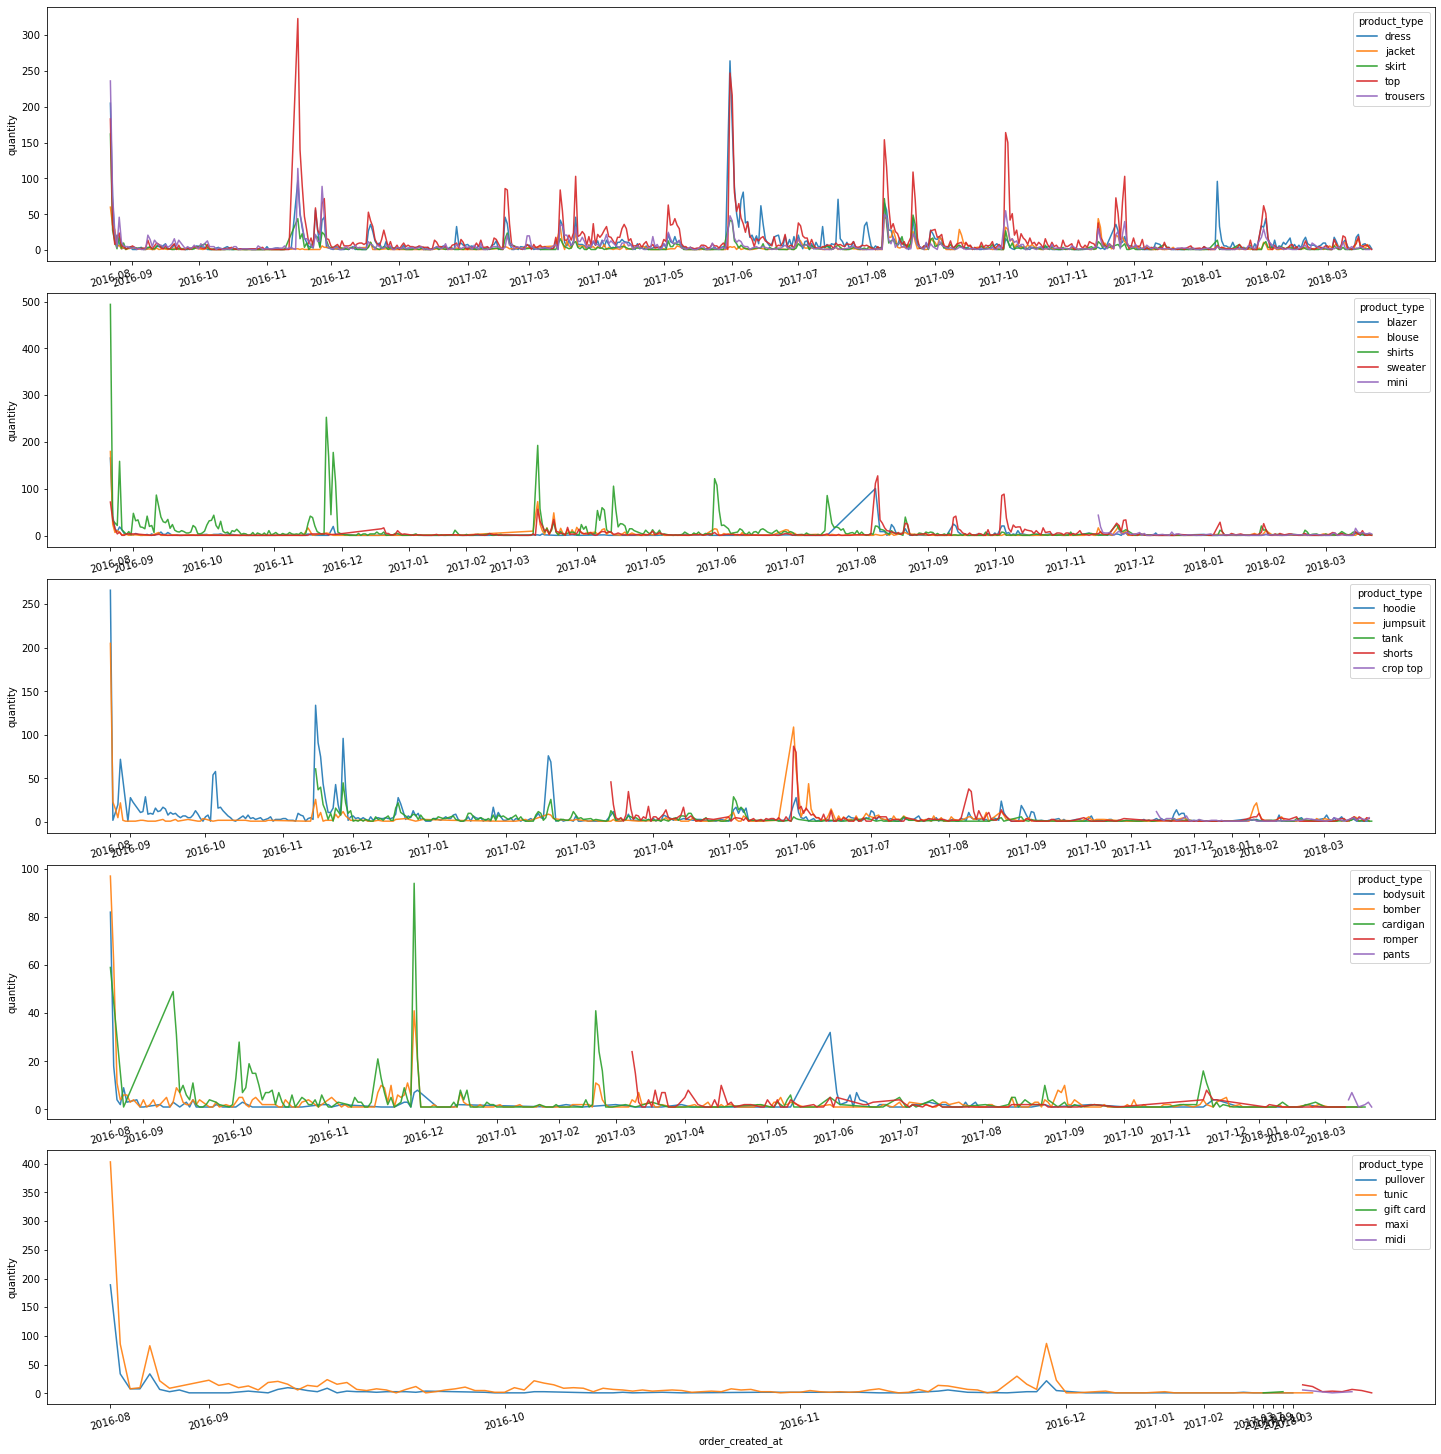

In [26]:
sales_trend_by_item = (pd.merge(orders.loc[lambda x: x['fulfillment_status'] == 'fulfilled'], 
                                transactions.loc[lambda x: x['transaction_status'] == 'success'], 
                                on='order_id')
                       .merge(ord_item, on='order_id')
                       .merge(products, on='product_id')
                       .groupby(['order_created_at', 'product_type'])[['quantity']].sum()
                       .reset_index())
sales_trend_by_item['y_m'] = sales_trend_by_item['order_created_at'].apply(lambda x: x[:7])

# now we split the product types into 5 tiers based on popularity
t1 = ['top', 'dress', 'trousers', 'jacket', 'skirt'] 
t2 = ['shirts', 'sweater', 'blazer', 'mini', 'blouse']
t3 = ['shorts', 'hoodie', 'jumpsuit', 'crop top', 'tank'] 
t4 = ['bodysuit', 'cardigan', 'bomber', 'pants', 'romper']
t5 = ['accessory', 'midi', 'pullover', 'maxi', 'gift card', 'tunic']
      
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))
fig.tight_layout()
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t1)], x='order_created_at', y='quantity', hue='product_type', ax=ax1, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t2)], x='order_created_at', y='quantity', hue='product_type', ax=ax2, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t3)], x='order_created_at', y='quantity', hue='product_type', ax=ax3, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t4)], x='order_created_at', y='quantity', hue='product_type', ax=ax4, alpha=0.9)
sns.lineplot(data=sales_trend_by_item.loc[lambda x: x['product_type'].isin(t5)], x='order_created_at', y='quantity', hue='product_type', ax=ax5, alpha=0.9);

def adjust_xticks(data, t, ax, rotation=15):
    xticks = data.loc[lambda x: x['product_type'].isin(t)][['order_created_at', 'y_m']].drop_duplicates().reset_index(drop=True).reset_index().groupby(['y_m'])['index'].first().tolist()
    xticklabels = data.loc[lambda x: x['product_type'].isin(t)]['y_m'].unique().tolist()
    data = data.reset_index().loc[lambda x: x['product_type'].isin(t)]
    ax.set_xticks(ticks=xticks)
    ax.set_xticklabels(labels=xticklabels, 
                       rotation=rotation)

adjust_xticks(sales_trend_by_item, t1, ax1)
adjust_xticks(sales_trend_by_item, t2, ax2)
adjust_xticks(sales_trend_by_item, t3, ax3)
adjust_xticks(sales_trend_by_item, t4, ax4)
adjust_xticks(sales_trend_by_item, t5, ax5)

* Sales trend by daily order

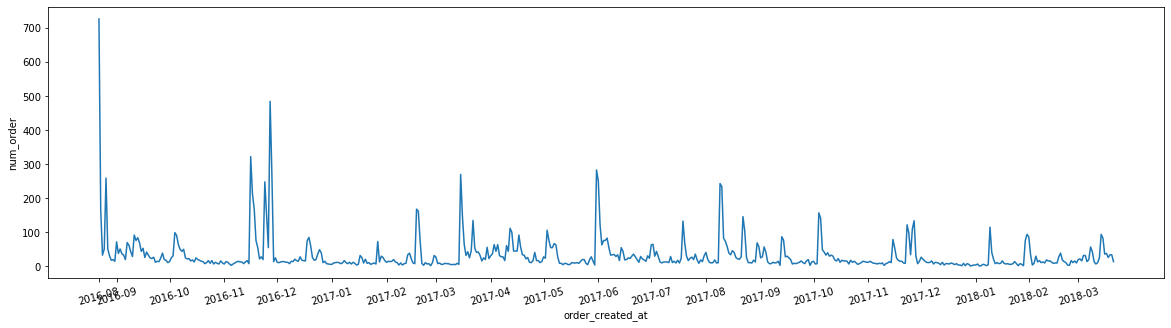

In [27]:
# here again, to make sure each order is closed and have brought revenue, we also make sure the it is not a fully refunded order.
sales_trend_by_order = (pd.merge(transactions, orders, on='order_id')
                        .loc[lambda x: 
                             (x['fulfillment_status'] == 'fulfilled') & 
                             (x['transaction_status'] == 'success') & 
                             (x['financial_status'] != 'refunded')]
                        .groupby(['order_created_at'])['order_id'].nunique()
                        .reset_index()
                        .rename(columns={'order_id':'num_order'}))

sales_trend_by_order['y_m'] = sales_trend_by_order['order_created_at'].apply(lambda x: x[:7])

plt.figure(figsize=(20, 5))
sns.lineplot(data=sales_trend_by_order, x='order_created_at', y='num_order');
plt.xticks(ticks=sales_trend_by_order.reset_index().groupby(['y_m'])['index'].first().tolist(),
           labels=sales_trend_by_order['y_m'].unique().tolist(),
           rotation=15);


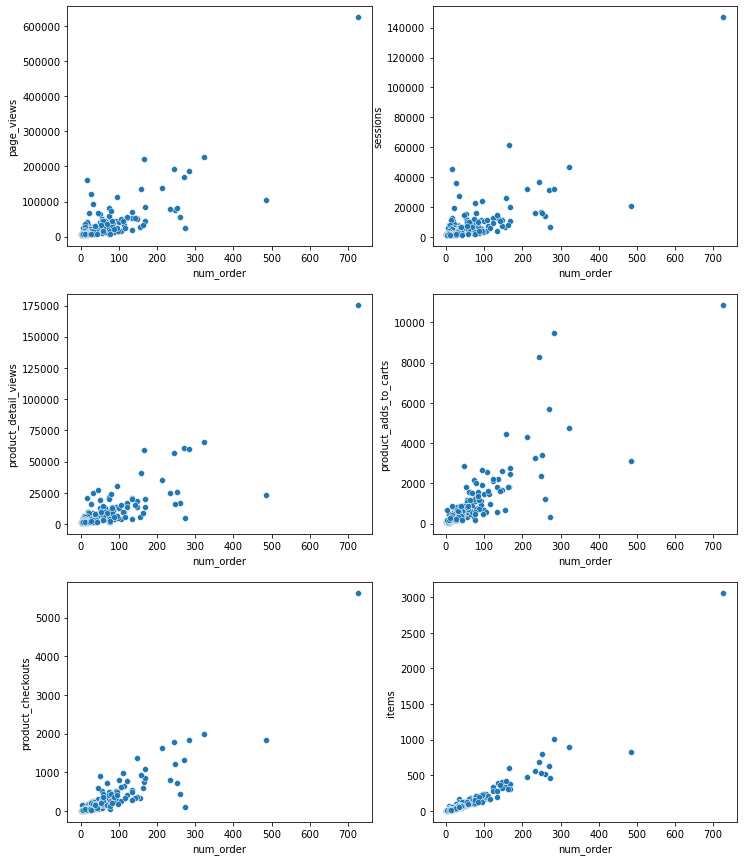

In [28]:
cor_traf_order = (traffic
                  .merge(sales_trend_by_order, 
                         left_on='date_day',
                         right_on='order_created_at')
                  .sort_values(by=['date_day']))

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
sns.scatterplot(data=cor_traf_order, y='page_views', x='num_order', ax=ax1)
sns.scatterplot(data=cor_traf_order, y='sessions', x='num_order', ax=ax2)
sns.scatterplot(data=cor_traf_order, y='product_detail_views', x='num_order', ax=ax3)
sns.scatterplot(data=cor_traf_order, y='product_adds_to_carts', x='num_order', ax=ax4)
sns.scatterplot(data=cor_traf_order, y='product_checkouts', x='num_order', ax=ax5);

cor_traf_item = (sales_trend_by_order
                 .merge(sales_trend_by_item
                        .groupby(['order_created_at'])['quantity'].sum()
                        .reset_index(),
                        on='order_created_at')
                 .sort_values(by=['order_created_at'])
                 .rename(columns={'quantity':'items'}))

sns.scatterplot(data=cor_traf_item, y='items', x='num_order', ax=ax6);

### Sales Funnel

* Overall Conversion Rates

In [67]:
orders

,order_id,order_created_at,order_closed_at,order_cancelled_at,customer_id,financial_status,fulfillment_status,order_processed_at,total_price,shipping_rate,subtotal_price,total_discounts,total_line_items_price
0,7675398239,2016-08-21,2016-08-25,2016-08-22,8683754719,voided,NaN,2016-08-21,44.57,6.33,35.0,0.0,35.0
1,7676331935,2016-08-22,2016-08-22,NaN,8686224991,refunded,NaN,2016-08-22,124.55,0.00,114.0,0.0,114.0
2,7676363167,2016-08-22,NaN,2016-08-22,8686224991,voided,NaN,2016-08-22,97.68,7.00,83.0,0.0,83.0
3,7676539359,2016-08-22,2016-08-22,NaN,8686915935,paid,fulfilled,2016-08-22,131.10,0.00,120.0,0.0,120.0
4,7676549855,2016-08-22,2016-08-22,NaN,8686924319,paid,fulfilled,2016-08-22,91.12,7.00,77.0,0.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21353,940077422077,2018-03-21,NaN,NaN,1063340479997,paid,NaN,2018-03-21,98.55,0.00,90.0,10.0,100.0
21354,940146726397,2018-03-21,NaN,NaN,829636843005,paid,NaN,2018-03-21,53.66,0.00,49.0,49.0,98.0
21355,940174775805,2018-03-21,NaN,NaN,1063472010749,paid,NaN,2018-03-21,100.00,0.00,100.0,0.0,100.0
21356,940182246909,2018-03-21,NaN,NaN,1063480464893,paid,NaN,2018-03-21,189.44,0.00,173.0,0.0,173.0


In [ ]:
# conversion table
col_order = ['page_views', 'product_detail_views', 'product_adds_to_carts', 'product_checkouts']
overall_conversion = traffic[col_order].sum().reset_index().rename(columns={'index':'sales_funnel', 0:'traffic'}).loc[lambda x: ~x['sales_funnel'].isin(['sessions', 'avg_session_in_s'])]
# orders
overall_orders= orders[['order_id']].count().reset_index().rename(columns={'index':'sales_funnel', 0:'traffic'})
overall_orders.loc[0, 'sales_funnel'] = 'placed_orders'
# closed orders
overall_closed_orders = (orders
                         .loc[lambda x: 
                              (x['order_id'].isin(transactions.loc[lambda x: x['transaction_status'] == 'success', 'order_id'].tolist())) &
                              (x['fulfillment_status'] == 'fulfilled')][['order_id']].count()
                         .reset_index()
                         .rename(columns={'index':'sales_funnel', 0:'traffic'}))
overall_closed_orders.loc[0, 'sales_funnel'] = 'closed_orders'
# profit orders
overall_profit_orders = (orders
                         .loc[lambda x: 
                              (x['order_id'].isin(transactions.loc[lambda x: x['transaction_status'] == 'success', 'order_id'].tolist())) &
                              (x['fulfillment_status'] == 'fulfilled') & 
                              (x['financial_status'] != 'refunded')][['order_id']].count()
                         .reset_index()
                         .rename(columns={'index':'sales_funnel', 0:'traffic'}))
overall_profit_orders.loc[0, 'sales_funnel'] = 'profit_orders'

overall_conversion = pd.concat([overall_conversion, overall_orders, overall_closed_orders, overall_profit_orders], axis=0)
overall_conversion['prev_lvl_traffic'] = overall_conversion['traffic'].shift(1)
overall_conversion['conversion_rate'] = np.round(overall_conversion['traffic'] / overall_conversion['prev_lvl_traffic'], 5)
overall_conversion['conversion_rate_on_pageview'] = np.round(overall_conversion['traffic'] / overall_conversion.loc[lambda x: x['sales_funnel'] == 'page_views', 'traffic'].values, 5)
overall_conversion

,sales_funnel,traffic,prev_lvl_traffic,conversion_rate,conversion_rate_on_pageview
0,page_views,10735976,NaN,NaN,1.00000
1,product_detail_views,2870342,10735976.0,0.26736,0.26736
2,product_adds_to_carts,289193,2870342.0,0.10075,0.02694
3,product_checkouts,84464,289193.0,0.29207,0.00787
0,placed_orders,21358,84464.0,0.25287,0.00199
0,closed_orders,19712,21358.0,0.92293,0.00184
0,profit_orders,19127,19712.0,0.97032,0.00178


In [29]:
prod_order = pd.merge(ord_item[['order_id', 'product_id', 'price', 'quantity']],
         products[['id', 'product_type', 'created_at','published_at']].rename(columns={'id':'product_id', 'created_at':'prod_created_at'}),
         on='product_id').merge(orders[['id', 'created_at', 'closed_at', 'cancelled_at', 'total_price', 'shipping_rate', 'subtotal_price', 'total_discounts', 'total_line_items_price']].rename(columns={'id':'order_id', 'created_at':'ord_created_at', 'closed_at':'ord_closed_at', 'cancelled_at':'ord_cancelled_at'}), on='order_id').sort_values(by=['order_id', 'product_id'])
prod_order

KeyError: "['created_at', 'id', 'published_at'] not in index"

In [ ]:
print('Total No. product types =', prod_order['product_type'].nunique())
prod_by_t = pd.pivot_table(prod_order,
               index='ord_created_at',
               columns='product_type',
               values='quantity',
               aggfunc=lambda x: sum(x),
               fill_value=0).reset_index().sort_values(by=['ord_created_at'])
prod_by_t.columns = [col.lower().replace(' ', '_') for col in prod_by_t.columns]
prod_by_t.head()

In [ ]:
print('Here we will start with top6 most bought product types to see the sales seasonal trends.')
top6_prod_type_list = ['top', 'dress', 'shirts', 'trousers', 'hoodie', 'sweater']
print('Top6:', top6_prod_type_list)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 20))
ind_list = np.arange(0, 577, 30)
for ax, col in zip((ax1, ax2, ax3, ax4, ax5, ax6), top6_prod_type_list):
    sns.lineplot(data=prod_by_t, x='ord_created_at', y=col, ax=ax)
    ax.set_xticks(ind_list)
    ax.set_xticklabels(labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=15)
#plt.xticks(ticks=ind_list, labels=prod_by_t.loc[lambda x: x.index.isin(ind_list)]['ord_created_at'], rotation=30);

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.round(prod_by_t.drop(columns=['ord_created_at']).corr(), 3), annot=True);

In [ ]:
prod_order

In [ ]:
prod_order.loc[lambda x: (x['total_discounts'] > 0) & (x['order_id'] == 7705038559)]

In [ ]:
# 3. How’s the sales of different products with discount? Does the discount promote sales?
prod_order['total_discounts_ratio'] = np.round((prod_order['total_line_items_price'] - prod_order['subtotal_price']) / prod_order['total_line_items_price'], 4)

# In general
plt.figure(figsize=(10, 10))
sns.boxplot(data=prod_order, y='total_discounts_ratio', x='quantity')

In [ ]:
#customers: ['id', 'full_name', 'created_at']
#orders: ['id', 'created_at', 'closed_at', 'cancelled_at', 'customer_id',
#         'financial_status', 'fulfillment_status', 'processed_at', 'total_price',
#         'shipping_rate', 'subtotal_price', 'total_discounts',
#         'total_line_items_price']
#transactions: ['order_id', 'id', 'parent_id', 'amount', 'error_code', 'kind', 'status', 'created_at']

In [ ]:
customer_order = pd.merge(customers.rename(columns={'id':'customer_id', 'created_at':'customer_created_at'}),
         orders.rename(columns={'id':'order_id', 'created_at':'order_created_at'}),
         on='customer_id',
         how='left')[['customer_id', 'full_name', 'customer_created_at', 'order_created_at', 'total_price']].sort_values(by=['customer_id', 'order_created_at'])
# monthly churn rate: number of consumed customers in month i who didn't consume in month i+1 / number of consumed customers in month i 
customer_order['y_m'] = customer_order['order_created_at'].apply(lambda x: x[:7] if type(x) == str else x)
churn = customer_order.groupby(['customer_id', 'full_name', 'y_m'])['order_created_at'].any().reset_index()

churn_id_list = [] 
for customer in churn['customer_id'].unique():
    for y_m in churn['y_m'].unique():
        churn_id_list.append([customer, y_m])
churn = pd.merge(pd.DataFrame(churn_id_list, columns=['customer_id', 'y_m']),
                 churn,
                 on=['customer_id', 'y_m'],
                 how='left').sort_values(by=['customer_id', 'y_m'])

In [ ]:
churn['is_active'] = churn['order_created_at'].apply(lambda x: 1 if x == True else 0)
churn['is_prev_active'] = churn['is_active'].shift(1).fillna(0)
churn.loc[(churn['is_prev_active'] == 1) & (churn['is_active'] == 0), 'is_churn'] = 1
churn['is_churn'] = churn['is_churn'].fillna(0)
churn.sort_values(by=['y_m'])
churn.groupby(['y_m']).apply(lambda x: x['is_churn'].sum() / x['is_prev_active'].sum()).reset_index()

In [ ]:
# 4. Dig more into the data and gain more insights, you can choose some E-commerce metrics or analysis (e.g. churn rate, conversion rate, retention rate, RFM analysis). 

In [ ]:
# 5. Based on the insights from all above questions, do you have any suggestion for the growth of sales?